In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Path to spykes.py
import sys
sys.path.insert(0, '../spykes/')

# Set the style
def set_style():
    #plt.style.use(['seaborn-white', 'fivethirtyeight'])
    plt.style.use(['seaborn-white', 'seaborn-pastel'])
    plt.rc("font", family="Arial")
    plt.style.use('./../spykes/mpl_configdir/spykes.mplstyle')  #to appear....
set_style()

# Start by simulating a neuron
We will load real data later in this tutorial

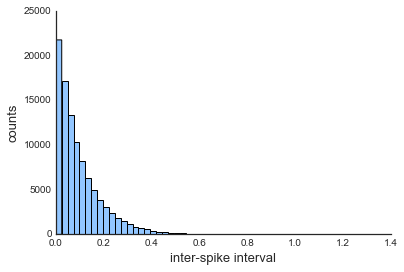

In [2]:
n_spikes = 100000
firing_rate = 10. # [spks/s]
av_inter_spk_interval = 1/firing_rate # average interspike interval [ms]

# Simulate
spike_times = np.cumsum(np.random.exponential(av_inter_spk_interval,n_spikes))

# Plot distribitution of inter-spike intervals
plt.hist(np.diff(spike_times),50)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('inter-spike interval')
ax.set_ylabel('counts')

# Load spykes package

In [3]:
import spykes as spy

# class: Spyke
### Instantiate neuron

In [4]:
neuron_id ='faker'   #choose name for neuron (not necessary)
neuron = spy.Spyke(spike_times, neuron_id)
neuron

<spykes.Spyke instance at 0x10ea73908>

# method:   .firingrate
does it have the firing rate we simulated?


In [5]:
firing_rate = neuron.firingrate

print 'neuron %s has a firing rate of %.2f spks/s' % (neuron.name, neuron.firingrate)

neuron faker has a firing rate of 10.02 spks/s


# method:   .get_psth
let's try a psth , we don't have an event....<br>
we can align it to spikes...


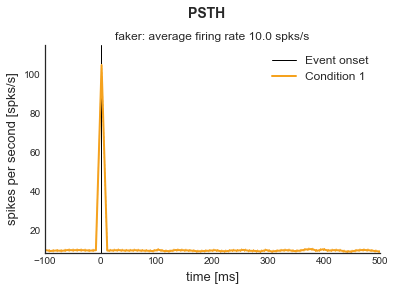

In [6]:
neuron.get_psth(spike_times[1000:10000], binsize=10);

hmmm that makes sense <br>
let's simulate an event

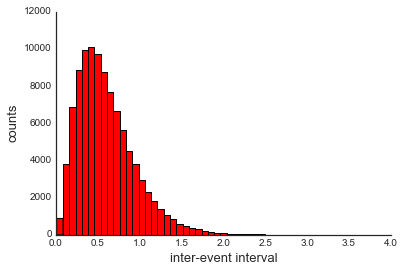

In [7]:
event_times = np.cumsum(np.random.gamma(3,0.2,100000))
plt.style.use('./../spykes/mpl_configdir/spykes.mplstyle') 

# Plot distribitution of inter-event intervals
plt.hist(np.diff(event_times), 50, color = 'r')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('inter-event interval')
ax.set_ylabel('counts') 

now let's look at the psth for this event

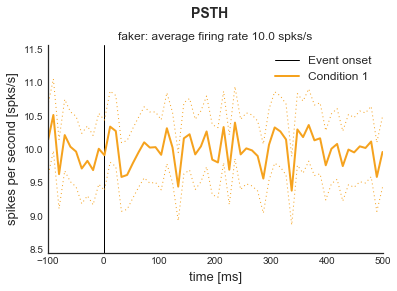

In [8]:
neuron.get_psth(event_times, binsize=10);

simulated neuron doesn't seem to be tuned to this independent event.... good

# Let's load some real data

In [9]:
# Packages for reading the data
import h5py
import deepdish as dd
import os
from skimage import io

# Load data
Monkey  = 'M1' #choose monkey
h5path = '/Volumes/JUICE/lab projects/V4_CNN/V4pydata/H5data/' + Monkey
fname = os.listdir(h5path)
fname = [session for session in fname if '.h5' in session]
thisfile = fname[0] #choose a session
dat = dd.io.load(h5path+'/'+ thisfile) #load

print 'loaded session: %s of monkey %s' % (thisfile[:-3], Monkey)
print "We have a dictionary with 2 fields: %s" % str(dat.keys())
print "and a total of %d neurons" % np.size(dat['spikes'].keys())

#let's get spikes and the list of neuron ids
spikes = dat['spikes']
neuron_list = dat['spikes'].keys()

loaded session: bucky090910 of monkey M1
We have a dictionary with 2 fields: ['eyes', 'spikes']
and a total of 142 neurons


In [10]:
#let's look at neuron number 50, for instance ;)
neuron_id = neuron_list[50]
spikes = dat['spikes'][neuron_id]

#instantiate neuron
neuron = spy.Spyke(spikes)

In [11]:
# what's its name?
neuron.name

'neuron'

that's boring let's give it a name

In [12]:
#that's boring let's give it a name
neuron = spy.Spyke(spikes, name = neuron_id)
neuron.name

'3301'

what's its firing rate?

In [13]:
print 'neuron %s has a firing rate of %.2f spks/s' % (neuron_id, neuron.firingrate)

neuron 3301 has a firing rate of 30.20 spks/s


nice, coincidently ;) we chose a neuron that spikes a lot #typicalneuron <br>
now we want to plot a PSTH, let's see what are our option of events

In [14]:
[i for i in dat['eyes'][0]]

['in_sac_blink',
 'imname',
 'fix_offset',
 'fix_offset_col',
 'badfix',
 'trial',
 'out_sac_blink',
 'out_sac_dur',
 'col',
 'fixation',
 'out_sac_pkvel',
 'in_sac_dur',
 'impath',
 'fix_onset',
 'fix_offset_row',
 'fix_onset_col',
 'in_sac_pkvel',
 'fix_onset_row',
 'row']

let's use fixation onset

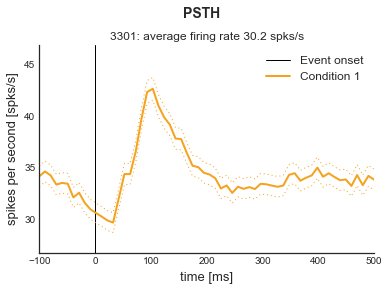

In [15]:
fix_onset_times = np.array([dat['eyes'][fix]['fix_onset'] for fix in dat['eyes']])
neuron.get_psth(fix_onset_times);

how about about a raster plot?

# method: .get_raster

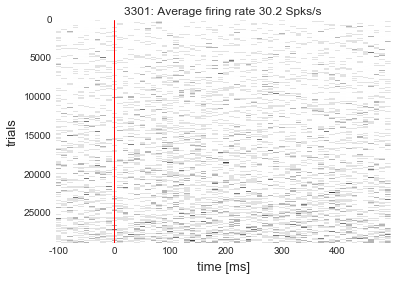

In [16]:
neuron.get_raster(fix_onset_times);

Let's restricting the trials to feature certain conditions <br>
First we get features

In [17]:
fix_onset_times = np.array([dat['eyes'][fix]['fix_onset'] for fix in dat['eyes']])
fix_offset_times = np.array([dat['eyes'][fix]['fix_offset'] for fix in dat['eyes']])
fix_col = np.array([dat['eyes'][fix]['col'] for fix in dat['eyes']])
fix_row = np.array([dat['eyes'][fix]['col'] for fix in dat['eyes']])

features = {}
features['fix_duration'] = (fix_offset_times-fix_onset_times)*1000
features['eye_pos_row'] = fix_row
features['eye_pos_col'] = fix_col
features['a_fake_feature'] = [] 

Now we impose some restriction on those features that define which subset of trials we in the PSTH

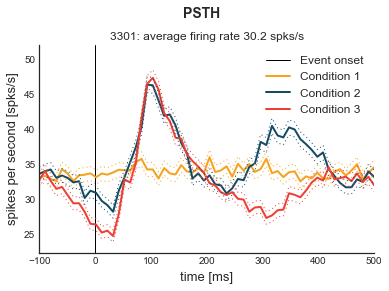

Condition 1: {'fix_duration': [0, 80], 'eye_pos_col': [1, 768], 'eye_pos_row': [1, 1024]}
Condition 2: {'fix_duration': [80, 200], 'eye_pos_col': [1, 768], 'eye_pos_row': [1, 1024]}
Condition 3: {'fix_duration': [200, 1000], 'eye_pos_col': [1, 768], 'eye_pos_row': [1, 1024]}


In [18]:
# Trials that are inside the screen
conditions = {}
conditions[0]= {}
conditions[0]['eye_pos_row'] = [1, 1024]
conditions[0]['eye_pos_col'] = [1, 768]
# and a fixation duration between [0, 80] ms
conditions[0]['fix_duration'] = [0, 80]

# or fixation duration between [80, 200] ms
conditions[1]= {}
conditions[1]['eye_pos_row'] = [1, 1024]
conditions[1]['eye_pos_col'] = [1, 768]
conditions[1]['fix_duration'] = [80, 200] 

# or fixation duration between [200, 1000] ms
conditions[2]= {}
conditions[2]['eye_pos_row'] = [1, 1024]
conditions[2]['eye_pos_col'] = [1, 768]
conditions[2]['fix_duration'] = [200, 1000]

neuron.get_psth(fix_onset_times, features, conditions);

Let's look at a bigget time window

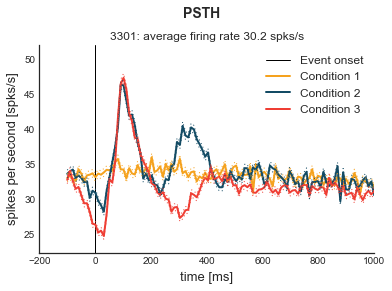

Condition 1: {'fix_duration': [0, 80], 'eye_pos_col': [1, 768], 'eye_pos_row': [1, 1024]}
Condition 2: {'fix_duration': [80, 200], 'eye_pos_col': [1, 768], 'eye_pos_row': [1, 1024]}
Condition 3: {'fix_duration': [200, 1000], 'eye_pos_col': [1, 768], 'eye_pos_row': [1, 1024]}


In [19]:
neuron.get_psth(fix_onset_times, features, conditions, window = [-100,1000]);

Default binsizes are 10 ms, let's try with 50 ms

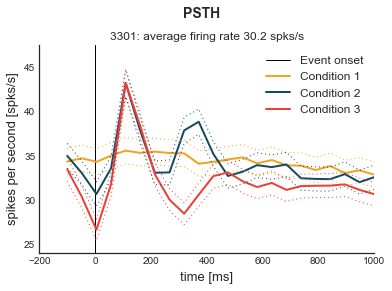

Condition 1: {'fix_duration': [0, 80], 'eye_pos_col': [1, 768], 'eye_pos_row': [1, 1024]}
Condition 2: {'fix_duration': [80, 200], 'eye_pos_col': [1, 768], 'eye_pos_row': [1, 1024]}
Condition 3: {'fix_duration': [200, 1000], 'eye_pos_col': [1, 768], 'eye_pos_row': [1, 1024]}


In [20]:
neuron.get_psth(fix_onset_times, features, conditions, window = [-100,1000], binsize=50);


And some rasters for the same conditions

In [ ]:
neuron.get_raster(fix_onset_times, features, conditions, sort=False);

we can ask both `.get_psth` and `.get_rasters` for data

In [28]:
PSTHs = neuron.get_psth(fix_onset_times, features, conditions, plot=False)
PSTHs

Condition 1: {'fix_duration': [0, 80], 'eye_pos_col': [1, 768], 'eye_pos_row': [1, 1024]}
Condition 2: {'fix_duration': [80, 200], 'eye_pos_col': [1, 768], 'eye_pos_row': [1, 1024]}
Condition 3: {'fix_duration': [200, 1000], 'eye_pos_col': [1, 768], 'eye_pos_row': [1, 1024]}


{0: {'mean': array([ 33.24449432,  33.53906579,  33.07616777,  32.79562351,
          34.47888904,  33.84766447,  32.7815963 ,  33.59517464,
          33.69336513,  33.88974611,  33.3286576 ,  33.86169168,
          33.69336513,  34.01599102,  34.39472577,  34.3245897 ,
          34.25445364,  35.47482115,  35.95174639,  34.45083462,
          34.43680741,  33.14630383,  34.63318839,  33.87571889,
          33.72141955,  35.06803198,  34.15626315,  34.01599102,
          34.61916117,  33.9879366 ,  36.19020901,  34.07209987,
          34.31056249,  34.88567822,  33.39879366,  35.25038575,
          34.29653528,  35.23635854,  34.1001543 ,  34.50694347,
          35.9657736 ,  33.90377332,  34.212372  ,  33.34268481,
          34.04404545,  34.17029036,  32.73951466,  33.45490251,
          33.16033104,  34.00196381,  33.16033104,  33.09019498,
          34.12820872,  34.47888904,  33.56712021,  34.29653528,
          35.1942769 ,  33.10422219,  33.93182775,  34.77346051]),
  'sem': arr

In [29]:
rasters = neuron.get_psth(fix_onset_times, features, conditions, plot=False)
rasters

Condition 1: {'fix_duration': [0, 80], 'eye_pos_col': [1, 768], 'eye_pos_row': [1, 1024]}
Condition 2: {'fix_duration': [80, 200], 'eye_pos_col': [1, 768], 'eye_pos_row': [1, 1024]}
Condition 3: {'fix_duration': [200, 1000], 'eye_pos_col': [1, 768], 'eye_pos_row': [1, 1024]}


{0: {'mean': array([ 33.24449432,  33.53906579,  33.07616777,  32.79562351,
          34.47888904,  33.84766447,  32.7815963 ,  33.59517464,
          33.69336513,  33.88974611,  33.3286576 ,  33.86169168,
          33.69336513,  34.01599102,  34.39472577,  34.3245897 ,
          34.25445364,  35.47482115,  35.95174639,  34.45083462,
          34.43680741,  33.14630383,  34.63318839,  33.87571889,
          33.72141955,  35.06803198,  34.15626315,  34.01599102,
          34.61916117,  33.9879366 ,  36.19020901,  34.07209987,
          34.31056249,  34.88567822,  33.39879366,  35.25038575,
          34.29653528,  35.23635854,  34.1001543 ,  34.50694347,
          35.9657736 ,  33.90377332,  34.212372  ,  33.34268481,
          34.04404545,  34.17029036,  32.73951466,  33.45490251,
          33.16033104,  34.00196381,  33.16033104,  33.09019498,
          34.12820872,  34.47888904,  33.56712021,  34.29653528,
          35.1942769 ,  33.10422219,  33.93182775,  34.77346051]),
  'sem': arr